In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import lib
import plotting

In [4]:
from multiprocessing import Pool
import pickle
from collections import defaultdict

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score
from sklearn.decomposition import PCA

In [6]:
from configparser import ConfigParser
cfg = ConfigParser()
cfg.read("config.cfg")

['config.cfg']

In [7]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm # we manually import the notebook submodule as the normal one struggles with jupyterlab
tqdm.pandas() # this enables us to use progress_apply instead of apply

In [8]:
results_prefix = "[WIKIDATA_NOBOT]"

sequence_file = os.path.join(cfg.get("directory", "exchange"), results_prefix + "001_clustering.p")
labels_file = os.path.join(cfg.get("directory", "exchange"), "[wikidata]004_labels.p")

In [9]:
df = pd.read_pickle(sequence_file)
labels = pd.read_pickle(labels_file)['label'].values
df.head()

,bot_name,bot_sequence,length,length_nobreak,sequence,user_id,user_name,is_bot,stat_dist,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
0,False,False,1529,1392,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...",1,Hoo man,False,"[0.02231964475186247, 0.01999468254492219, 0.0...",1,0,3,1,4,3,5,2,4
1,False,False,9,6,"[ENTITY_CREATE, BREAK, SITELINK_ADD, BREAK, ME...",1000036,JShenk,False,"[0.020070153072094386, 0.02007015307209438, 0....",0,0,1,3,0,6,3,1,7
2,False,False,7,4,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...",1000078,Egor-belikov,False,"[0.01947397679104996, 0.019473976791049966, 0....",0,1,2,0,3,1,1,3,1
3,False,False,9,6,"[ENTITY_CREATE, BREAK, SITELINK_REMOVE, SITELI...",100008,Wars,False,"[0.02042483183496783, 0.020424831834967825, 0....",0,1,2,0,3,1,1,1,7
4,False,False,44,23,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...",100012,Kane 14,False,"[0.01973684210526316, 0.019736842105263157, 0....",0,1,2,0,3,1,1,3,1


In [10]:
len(df)

71605

In [11]:
break_label = cfg.get("preprocessing", "break_label")
break_label

'BREAK'

In [12]:
df.head()

,bot_name,bot_sequence,length,length_nobreak,sequence,user_id,user_name,is_bot,stat_dist,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
0,False,False,1529,1392,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...",1,Hoo man,False,"[0.02231964475186247, 0.01999468254492219, 0.0...",1,0,3,1,4,3,5,2,4
1,False,False,9,6,"[ENTITY_CREATE, BREAK, SITELINK_ADD, BREAK, ME...",1000036,JShenk,False,"[0.020070153072094386, 0.02007015307209438, 0....",0,0,1,3,0,6,3,1,7
2,False,False,7,4,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...",1000078,Egor-belikov,False,"[0.01947397679104996, 0.019473976791049966, 0....",0,1,2,0,3,1,1,3,1
3,False,False,9,6,"[ENTITY_CREATE, BREAK, SITELINK_REMOVE, SITELI...",100008,Wars,False,"[0.02042483183496783, 0.020424831834967825, 0....",0,1,2,0,3,1,1,1,7
4,False,False,44,23,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...",100012,Kane 14,False,"[0.01973684210526316, 0.019736842105263157, 0....",0,1,2,0,3,1,1,3,1


In [13]:
print(len(df), df['length'].sum())
#df = df.loc[~df['is_bot']].reset_index(drop=True)
print(len(df), df['length'].sum())

71605 78333501
71605 78333501


In [14]:
length_full = df.sort_values("length", ascending=False)['length'].values
length_nobreak = df.sort_values("length_nobreak", ascending=False)['length_nobreak'].values

In [15]:
from matplotlib import pyplot as plt

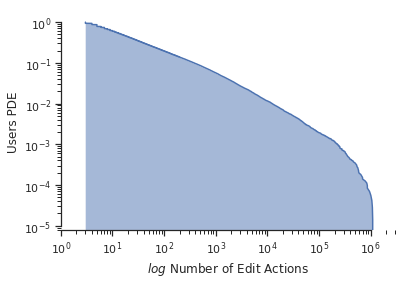

In [23]:
import seaborn as sns
import matplotlib

fig, ax = plt.subplots()
ax.loglog(length_full, np.linspace(0,1,len(length_full)))
ax.fill_between(length_full, np.linspace(0,1,len(length_full)), alpha=0.5)
ax.set_xlim(left=1)
#ax.set_ylim(0,1)
#ax.plot(length_nobreak)
#ax.set_xscale("log")
#ax.set_yscale("log", nonposy='clip')
ax.set_ylabel("Users PDE")
ax.set_xlabel("$log$ Number of Edit Actions")
#ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
sns.despine(fig, trim=True)

In [24]:
fig.tight_layout()
store_path = os.path.join(cfg.get("directory", "results"), results_prefix + "dataset_pde")
fig.savefig(store_path + ".png", transparent=True, bbox_inches="tight")
fig.savefig(store_path + ".pdf", transparent=True, bbox_inches="tight")